In [1]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
from scipy import stats
from scipy.optimize import curve_fit
from scipy import odr
import glob
import os

In [2]:
X1 = [0.013,0.014,0.0145,0.015,0.016,0.0175,0.019,0.02,0.021,0.0225,0.024,0.025,0.026,0.0265,0.0275,0.0285,0.03,0.031,0.0315]
X2 = np.array([0.013,0.015,0.0155,0.016,0.016,0.016,0.017,0.018,0.019,0.02,0.02,0.021,0.022,0.022])
X3 = np.array([0.0165,0.018,0.0195,0.022,0.022,0.023,0.0235,0.0245,0.0255,0.027,0.0285,0.03,0.031,0.032,0.0335,0.036])
X4 = np.array([0.016,0.017,0.018,0.0185,0.0195,0.02,0.02,0.021,0.022,0.023,0.024,0.0245,0.0245,0.0255,0.0255,0.026,0.027,0.0275,0.028,0.0285,0.029,0.03,0.0305,0.031,0.0315,0.032,0.033,0.0335,0.034,0.0355,0.036,0.0375,0.0385,0.0395,0.0405,0.0415,0.0425])


In [3]:
hz_water1 = np.array([50, 60, 65, 70, 80, 90, 100, 110, 120, 130, 140, 150, 160, 170, 180, 190, 200, 210, 220])
hz_water2 = np.array([70, 80, 90, 95, 100, 105, 110, 120, 130, 140, 150, 160, 170, 180])
hz_water3 = np.array([60, 70, 80, 90, 95, 100, 105, 110, 120, 130, 140, 150, 160, 170, 180, 190])
hz_water4 = np.array([140, 150, 160, 170, 180, 190, 200, 210, 220, 230, 240, 250, 260, 270, 280, 290, 300, 310, 320, 330, 340, 350, 360, 370, 380, 390, 400, 420,440,460,480,500,520,540,560,580,600])

Surface Tension of water is 4.280561678851273 +- 1.3506455085631646 mN/M
Surface Tension of water is 0.19129602152500805 +- 0.1618244167513832 mN/M
Surface Tension of water is 6.775395418758352 +- 2.4253414901312027 mN/M
Surface Tension of water is 37.08251508769528 +- 5.301059308673836 mN/M


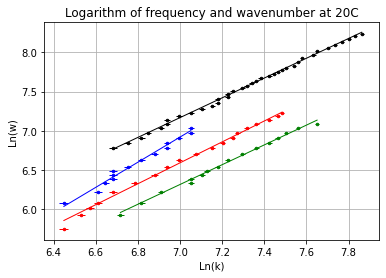

In [4]:
dens = [998,998,998,998]
cols = ['r','b','g','k']
sols = [1,1,1,1]
hzs = [hz_water1, hz_water2, hz_water3, hz_water4]
X = [X1,X2,X3,X4]

#plt.figure(figsize = (20,11))
plt.grid()

for hzs, X, sols,c,p in zip(hzs, X, sols, cols,dens):
    #Laser wavelength, distance of the 0th order image above water, and the distance between the screen and laser
    laz = 632.8e-9
    x = 0.0492
    y = 0.4838
    theta = np.arcsin( x / np.sqrt( (x**2)+(y**2))  )
    l = 4.838
    x1 = 1*np.tan(theta)
    k = []
    for i in X:
        h = x1 + i 
        j = 2*i
        m = ( np.pi*h*j ) / ( laz*((h**2)+l**2) )
        k.append(m)
    #logs of the values for the lnk lnw relation
    lnk = np.log(k)
    w = 2 * hzs * np.pi
    lnw = np.log(w)
    
    #all code below follows a propogation of errors following pm the smallest decimal of each data point i.e 0.0005
    xerr = yerr = 0.0005
    dfdx =  y / ( (x**2) + (y**2) )
    dfdy = -x / ( (x**2) + (y**2) )
    theterr = np.sqrt( (dfdx**2) * (xerr**2) + (dfdy**2) * (yerr**2) )
    
    Xx1 = l*np.tan(theta)
    lerr = 0.0005
    dfdl = np.tan(theta)
    dfdt = 1 / (np.cos(theta)**2)
    Xerr = np.sqrt ( (dfdl**2) * (lerr**2) + (dfdt**2) * (theterr**2) )
    
    lnkerr = []
    dfdl = - ( (2*l) / ( (h**2) + (l**2)) )
    dfdh = - ( (h**2) - (l**2) ) / ( (h**3) + h*(l**2) )
    
    for i in X:
        d = 2*i
        derr = 0.0005
        h = Xx1 + d/2
        dhdx = 1
        dhdd = 1/2
        herr = np.sqrt( (dhdx**2) * (Xerr**2) + (dhdd**2) * (derr**2) )
        dfdd = 1/d
        
        lnkerrv = np.sqrt( (dfdh**2) * (herr**2) + (dfdd**2) * (derr**2) + (dfdl**2) * (lerr**2) )
        lnkerr.append(lnkerrv)
        
    lnwerr = []
    for i in hzs:
        lnwerrv = np.sqrt( ( (1/i)**2) * ( (0.5)**2) )
        lnwerr.append(lnwerrv)
    
    #Errors of lnk and lnw   
    plt.errorbar(lnk, lnw, lnwerr, lnkerr, '.', markersize = 5, linewidth = 1, color = c)
    
    def func(p, x):
        m, c = p
        return m*x + c 
    
    data = odr.RealData( lnk, lnw, sx = lnkerr, sy = lnwerr)
    lin = odr.Model(func)
    odr1 = odr.ODR(data, lin, beta0 = [1, -5])
    out = odr1.run()
    
    errsurf = np.sqrt(((2*p*np.exp( 2*( out.beta[1]) ) )**2) * ( (out.sd_beta[1])**2) )
    
    y = out.beta[0] * lnk + out.beta[1]
    plt.plot(lnk,y,linewidth=1,color=c)
    plt.title('Logarithm of frequency and wavenumber at 20C')
    plt.xlabel('Ln(k)')
    plt.ylabel('Ln(w)')
    
    
    
    surf = p*np.exp(2*out.beta[1])
    print('Surface Tension of water is',surf,'+-',errsurf, 'mN/M')
    
plt.savefig('Surface tension runs')